In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf

  Activating environment at `C:\Users\hilld\Documents\git\ocrl\ocrl_quadruped_mpc\convex_mpc_approach\Project.toml`


## Dynamics

In [2]:
function skew_symmetric(r::Vector) #function to convert vector to cross-product skew-symmetric matrix
    R = [0 -r[3] r[2]; r[3] 0 -r[1]; -r[2] r[1] 0]
    return R
end

function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

function R_z(sigma::Real) #rotation matrix of rotation sigma about z-axis
     R = [cos(sigma) sin(sigma) 0; -sin(sigma) cos(sigma) 0; 0 0 1]
    return R
end

#dynamics function of quadruped
function dynamics(model::NamedTuple, x::Vector, u::Vector, r1::Vector, r2::Vector, r3::Vector, r4::Vector)
    #state is defined as [x,theta,x_dot,theta_dot]^T
    #force is defined as [fl,fr,bl,br]^T where each one is composed of x,y,z forces
    
    m, J = model.m, R_z(x[6]) * model.J * transpose(R_z(x[6])) #transform the moment of inertia from the body to the world frame
    
    #A matrix, or mass matrix
    A = vcat(hcat(zeros(6,6), vcat(hcat(Matrix{Float64}(I,3,3),zeros(3,3)),hcat(zeros(3,3),R_z(x[6])))), zeros(6,12)) #A matrix
    #B1 is first 9 rows of B matrix, first 6 rows are zeros, next rows are F = ma
    B1 = vcat(zeros(6,12), 1/m * hcat(hcat(Matrix{Float64}(I,3,3),Matrix{Float64}(I,3,3)),hcat(Matrix{Float64}(I,3,3),Matrix{Float64}(I,3,3))))
    #B2 is last 3 rows of B matrix effecting theta_dot, these are tau = J*theta_dot
    B2 = hcat(hcat(J \ skew_symmetric(r1 - x[1:3]), J \ skew_symmetric(r2 - x[1:3])),hcat(J \ skew_symmetric(r3 - x[1:3]), J \ skew_symmetric(r4 - x[1:3])))
    B = vcat(B1,B2) #add B1 to B2 to get full B matrix
    C = vcat(vcat(zeros(8),1),zeros(3)) #gravity term    
    
    #add gravity to the A and B matrix
    Ag = vcat(hcat(A,C),zeros(1,13))
    Bg = vcat(B,zeros(1,12))
    
    x_dot = Ag * x + Bg * u #calculate x_dot (full state derivative)
    
    return x_dot
end

#rk4 function for discritization of dynamics
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, r1::Vector, r2::Vector, r3::Vector, r4::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u, r1, r2, r3, r4)
    k2 = dt * ode(model, x + k1/2, u, r1, r2, r3, r4)
    k3 = dt * ode(model, x + k2/2, u, r1, r2, r3, r4)
    k4 = dt * ode(model, x + k3,   u, r1, r2, r3, r4)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end


rk4 (generic function with 1 method)

## Reference Trajectory and Gait Planner

In [3]:
function generate_linear_path(length, N) #generates a linear path
    x = zeros(N)
    y = zeros(N)
    theta = zeros(N)
    
    for i = 1:N #linear interpolation to make path
       x[i] = (i-1) * length / (N-1)
    end
    
    return x, y, theta
end

function generate_circular_path(radius, N) #generates a circular path 
    x = zeros(N)
    y = zeros(N)
    theta = zeros(N)
    
    for i = 1:N #interpolation about a circle with given radius
        x[i] = radius * sin(2*pi*(i-1)/(N-1))
        y[i] = radius * (1 - cos(2*pi*(i-1)/(N-1)))
        theta[i] = 2*pi*(i-1)/(N-1)
    end
    return x, y, theta
end
    
function generate_body_trajectory(model, x, y, theta, speed, N) #generates trajectory based on path and speed
    Xref = [zeros(13) for i = 1:N]
        
    Xref[1] = [x[1], y[1], model.h, 0, 0, theta[1], 0, 0,0,0,0,0,model.g] #always start and stop with velocity 0
    Xref[N] = [x[N], y[N], model.h, 0, 0, theta[N], 0, 0,0,0,0,0,model.g]
    
    for i = 2:N-1 #caculate speed and combine into state vector
        v_x_temp = speed * cos(theta[i])
        v_y_temp = speed * sin(theta[i])
        Xref[i] = [x[i], y[i], model.h, 0, 0, theta[i], v_x_temp, v_y_temp,0,0,0,0,model.g]
    end
    
    return Xref
end

function generate_walk_foot_timings(num_gaits, N) #generate foot timings for a walking gait
    quarter_gait = Int((N - 2) / (num_gaits * 4))  
    
    fl_timing = zeros(N) #initialize fl_timing etc. These are the gait timings
    fl_timing[1] = 1 #start and stop with all four feet on the ground
    fl_timing[N] = 1
    fr_timing = zeros(N)
    fr_timing[1] = 1
    fr_timing[N] = 1
    bl_timing = zeros(N)
    bl_timing[1] = 1    
    bl_timing[N] = 1
    br_timing = zeros(N)
    br_timing[1] = 1
    br_timing[N] = 1
    
    state = 0
    for i = 2:quarter_gait:N-1  #every quarter gait, move one foot forward
        if(state == 0)
            fl_timing[i:i+quarter_gait-1] = zeros(quarter_gait)
            fr_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            bl_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            br_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            state = 1
        elseif(state == 1)
            fl_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            fr_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            bl_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            br_timing[i:i+quarter_gait-1] = zeros(quarter_gait)
            state = 2
        elseif(state == 2)
            fl_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            fr_timing[i:i+quarter_gait-1] = zeros(quarter_gait)
            bl_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            br_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            state = 3
        elseif(state == 3)
            fl_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            fr_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            bl_timing[i:i+quarter_gait-1] = zeros(quarter_gait)
            br_timing[i:i+quarter_gait-1] = ones(quarter_gait)
            state = 0
        end
    end
    
    return fl_timing, fr_timing, bl_timing, br_timing
end

function generate_trot_foot_timings(num_gaits, N) #generate foot timings for a trotting gait
    half_gait = Int((N - 2) / (num_gaits * 2))
    
    fl_timing = zeros(N) #initialize fl_timing etc. These are the gait timings
    fl_timing[1] = 1 #start and stop with all four feet on the ground
    fl_timing[N] = 1
    fr_timing = zeros(N)
    fr_timing[1] = 1
    fr_timing[N] = 1
    bl_timing = zeros(N)
    bl_timing[1] = 1    
    bl_timing[N] = 1
    br_timing = zeros(N)
    br_timing[1] = 1
    br_timing[N] = 1
    
    state = 0
    for i = 2:half_gait:N-1 #every half gait switch feet: either (FL & BR) or (FR & BL)
        if(state == 0)
            fl_timing[i:i+half_gait-1] = zeros(half_gait)
            fr_timing[i:i+half_gait-1] = ones(half_gait)
            bl_timing[i:i+half_gait-1] = ones(half_gait)
            br_timing[i:i+half_gait-1] = zeros(half_gait)
            state = 1
        elseif(state == 1)
            fl_timing[i:i+half_gait-1] = ones(half_gait)
            fr_timing[i:i+half_gait-1] = zeros(half_gait)
            bl_timing[i:i+half_gait-1] = zeros(half_gait)
            br_timing[i:i+half_gait-1] = ones(half_gait)
            state = 0
        end
    end
    
    return fl_timing, fr_timing, bl_timing, br_timing
end

#generate foot placement based on reference trajectory and foot timing
function generate_foot_placement(model, Xref, fl_timing, fr_timing, bl_timing, br_timing, gait_period, N)
    l, w = model.l, model.w
    
    r_fl = [zeros(3) for i=1:N] #initialize r vectors (position of each foot over time)
    r_fr = [zeros(3) for i=1:N]
    r_bl = [zeros(3) for i=1:N]
    r_br = [zeros(3) for i=1:N]
    
    #start standing up straight, l/2, w/2, and yaw angle used to get hip position relative to COM
    r_fl[1] = [l/2 * cos(Xref[1][6]) - w/2 * sin(Xref[1][6]) + Xref[1][1], w/2 * cos(Xref[1][6]) + l/2 * sin(Xref[1][6]) + Xref[1][2], 0]
    r_fr[1] = [l/2 * cos(Xref[1][6]) + w/2 * sin(Xref[1][6]) + Xref[1][1], -w/2 * cos(Xref[1][6]) + l/2 * sin(Xref[1][6]) + Xref[1][2], 0]
    r_bl[1] = [-l/2 * cos(Xref[1][6]) - w/2 * sin(Xref[1][6]) + Xref[1][1], w/2 * cos(Xref[1][6]) - l/2 * sin(Xref[1][6]) + Xref[1][2], 0]
    r_br[1] = [-l/2 * cos(Xref[1][6]) + w/2 * sin(Xref[1][6]) + Xref[1][1], -w/2 * cos(Xref[1][6]) - l/2 * sin(Xref[1][6]) + Xref[1][2], 0]
    
    #end standing up straight
    r_fl[N] = [l/2 * cos(Xref[N][6]) - w/2 * sin(Xref[N][6]) + Xref[N][1], w/2 * cos(Xref[N][6]) + l/2 * sin(Xref[N][6]) + Xref[N][2], 0]
    r_fr[N] = [l/2 * cos(Xref[N][6]) + w/2 * sin(Xref[N][6]) + Xref[N][1], -w/2 * cos(Xref[N][6]) + l/2 * sin(Xref[N][6]) + Xref[N][2], 0]
    r_bl[N] = [-l/2 * cos(Xref[N][6]) - w/2 * sin(Xref[N][6]) + Xref[N][1], w/2 * cos(Xref[N][6]) - l/2 * sin(Xref[N][6]) + Xref[N][2], 0]
    r_br[N] = [-l/2 * cos(Xref[N][6]) + w/2 * sin(Xref[N][6]) + Xref[N][1], -w/2 * cos(Xref[N][6]) - l/2 * sin(Xref[N][6]) + Xref[N][2], 0]
     
    for i = 2:N-1 #for each sequential half gait, set legs reaching past shoulders to start
        #by default, the foot position does not change (planted)
        r_fl[i] = r_fl[i-1]
        r_fr[i] = r_fr[i-1]
        r_bl[i] = r_bl[i-1]
        r_br[i] = r_br[i-1]
        #if the foot is moved (planted anew) update the position using the Raibert heuristic
        if((fl_timing[i-1] == 0) & (fl_timing[i] == 1))
            r_fl[i] = [l/2 * cos(Xref[i][6]) - w/2 * sin(Xref[i][6]) + Xref[i][1] + gait_period/2 * Xref[i][7], w/2 * cos(Xref[i][6]) + l/2 * sin(Xref[i][6]) + Xref[i][2] + gait_period/2 * Xref[i][8], 0]
        end
        if((fr_timing[i-1] == 0) & (fr_timing[i] == 1))
            r_fr[i] = [l/2 * cos(Xref[i][6]) + w/2 * sin(Xref[i][6]) + Xref[i][1] + gait_period/2 * Xref[i][7], -w/2 * cos(Xref[i][6]) + l/2 * sin(Xref[i][6]) + Xref[i][2] + gait_period/2 * Xref[i][8], 0]
        end
        if((bl_timing[i-1] == 0) & (bl_timing[i] == 1))
            r_bl[i] = [-l/2 * cos(Xref[i][6]) - w/2 * sin(Xref[i][6]) + Xref[i][1] + gait_period/2 * Xref[i][7], w/2 * cos(Xref[i][6]) - l/2 * sin(Xref[i][6]) + Xref[i][2] + gait_period/2 * Xref[i][8], 0]
        end
        if((br_timing[i-1] == 0) & (br_timing[i] == 1))
            r_br[i] = [-l/2 * cos(Xref[i][6]) + w/2 * sin(Xref[i][6]) + Xref[i][1] + gait_period/2 * Xref[i][7], -w/2 * cos(Xref[i][6]) - l/2 * sin(Xref[i][6]) + Xref[i][2] + gait_period/2 * Xref[i][8], 0]
        end
    end
    
    return r_fl, r_fr, r_bl, r_br
end

function gait_planner(model, speed, num_gaits, path, gait, dim, timesteps_per_gait) #plans a trajectory based on parameters
    N = num_gaits * timesteps_per_gait + 2
    if cmp(path,"linear") == 0 #if linear
        dt = dim / speed / (N - 2)
        gait_period = timesteps_per_gait * dt
        if cmp(gait,"walk") == 0 #if walking gait
            x, y, theta = generate_linear_path(dim, N)
            Xref = generate_body_trajectory(model, x, y, theta, speed, N)
            fl_timing, fr_timing, bl_timing, br_timing = generate_walk_foot_timings(num_gaits, N)
            r_fl, r_fr, r_bl, r_br = generate_foot_placement(model, Xref, fl_timing, fr_timing, bl_timing, br_timing, gait_period, N)
            return N, dt, gait_period, Xref, fl_timing, fr_timing, bl_timing, br_timing, r_fl, r_fr, r_bl, r_br
        elseif cmp(gait,"trot") == 0 #if trotting gait
            x, y, theta = generate_linear_path(dim, N)
            Xref = generate_body_trajectory(model, x, y, theta, speed, N)
            fl_timing, fr_timing, bl_timing, br_timing = generate_trot_foot_timings(num_gaits, N)
            r_fl, r_fr, r_bl, r_br = generate_foot_placement(model, Xref, fl_timing, fr_timing, bl_timing, br_timing, gait_period, N)
            return N, dt, gait_period, Xref, fl_timing, fr_timing, bl_timing, br_timing, r_fl, r_fr, r_bl, r_br
        end    
    elseif cmp(path,"circular") == 0 #if circular
        dt = 2 * pi * dim / speed / (N - 2)
        gait_period = timesteps_per_gait * dt
        if cmp(gait,"walk") == 0 #if walking gait
            x, y, theta = generate_circular_path(dim, N)
            Xref = generate_body_trajectory(model, x, y, theta, speed, N)
            fl_timing, fr_timing, bl_timing, br_timing = generate_walk_foot_timings(num_gaits, N)
            r_fl, r_fr, r_bl, r_br = generate_foot_placement(model, Xref, fl_timing, fr_timing, bl_timing, br_timing, gait_period, N)
            return N, dt, gait_period, Xref, fl_timing, fr_timing, bl_timing, br_timing, r_fl, r_fr, r_bl, r_br
        elseif cmp(gait,"trot") == 0 #if trotting gait
            x, y, theta = generate_circular_path(dim, N)
            Xref = generate_body_trajectory(model, x, y, theta, speed, N)
            fl_timing, fr_timing, bl_timing, br_timing = generate_trot_foot_timings(num_gaits, N)
            r_fl, r_fr, r_bl, r_br = generate_foot_placement(model, Xref, fl_timing, fr_timing, bl_timing, br_timing, gait_period, N)
            return N, dt, gait_period, Xref, fl_timing, fr_timing, bl_timing, br_timing, r_fl, r_fr, r_bl, r_br
        end
    end
    
end


gait_planner (generic function with 1 method)

## Generate Reference Trajectory

[ Info: Saved animation to C:\Users\hilld\Documents\git\ocrl\ocrl_quadruped_mpc\convex_mpc_approach\anim.gif


Plots.AnimatedGif("C:\\Users\\hilld\\Documents\\git\\ocrl\\ocrl_quadruped_mpc\\convex_mpc_approach\\anim.gif")
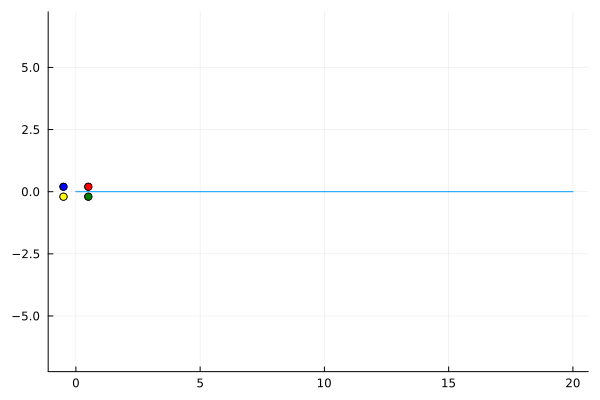

In [4]:
#set parameters for run
speed = 2.0
path = "linear"
gait = "trot"
dim = 20
mu = 0.6

num_gaits = 30
timesteps_per_gait = 8

model = (g = -9.81, m = 5.0, J = diagm([1,5.2,5.8]), l = 1.0, w = 0.4, h = 0.6, mu = mu)

#get reference trajectory variables
N, dt, gait_period, Xref, fl_timing, fr_timing, bl_timing, br_timing, r_fl, r_fr, r_bl, r_br = gait_planner(model, speed, num_gaits, path, gait, dim, timesteps_per_gait)

tf = N * dt
t_vec = 0:dt:tf

Xref_an = hcat(Xref...)
r_fl_an = hcat(r_fl...)
r_fr_an = hcat(r_fr...)
r_bl_an = hcat(r_bl...)
r_br_an = hcat(r_br...)

#create animation of the footsteps on top of the reference trajectory
anim = @animate for i = 1:N-1
    plot(Xref_an[1,:], Xref_an[2,:])
    if fl_timing[i] == 1
        scatter!(r_fl_an[1,i:i+1], r_fl_an[2,i:i+1], legend=false, color=:red, aspect_ratio=:equal)
    end
    if fr_timing[i] == 1
        scatter!(r_fr_an[1,i:i+1], r_fr_an[2,i:i+1], legend=false, color=:green, aspect_ratio=:equal)
    end
    if bl_timing[i] == 1
        scatter!(r_bl_an[1,i:i+1], r_bl_an[2,i:i+1], legend=false, color=:blue, aspect_ratio=:equal)
    end
    if br_timing[i] == 1
        scatter!(r_br_an[1,i:i+1], r_br_an[2,i:i+1], legend=false, color=:yellow, aspect_ratio=:equal)
    end
end
gif(anim, "anim.gif", fps = 10)

## Solve


ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+000  -1.724e+004  +7e+005  8e-001  9e-001  1e+000  1e+002    ---    ---    2  3  - |  -  - 
 1  +2.175e+003  -1.497e+004  +7e+005  7e-001  3e-002  1e+001  1e+002  0.0873  9e-001   2  3  2 |  0  0
 2  +2.218e+003  -9.696e+003  +6e+005  5e-001  3e-002  4e+001  1e+002  0.3964  8e-001   3  3  2 |  0  0
 3  -1.615e+003  -2.756e+003  +1e+005  5e-002  2e-003  2e+001  2e+001  0.9022  1e-001   2  3  2 |  0  0
 4  -2.971e+002  -5.235e+002  +4e+004  1e-002  9e-004  4e+000  6e+000  0.7644  4e-002   2  2  2 |  0  0
 5  -8.912e+001  -1.374e+002  +9e+003  3e-003  6e-004  2e-001  1e+000  0.9890  2e-001   2  2  2 |  0  0
 6  -5.783e+001  -8.885e+001  +6e+003  2e-003  5e-004  9e-002  1e+000  0.5924  4e-001   1  1  2 |  0  0
 7  -4.674e+001  -7.191e+001  +5e+003  1e-003  3e-004  7e-002  8e-001  0.3543  4e-001  

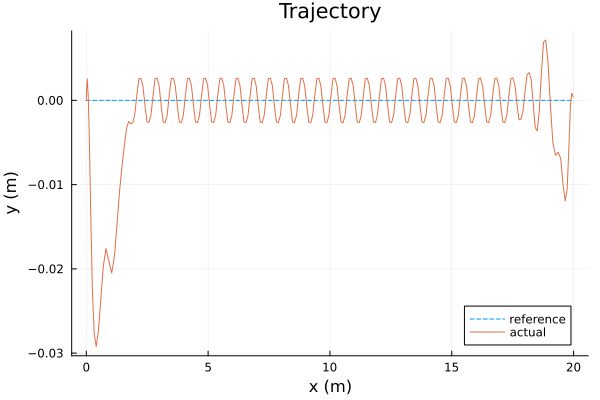

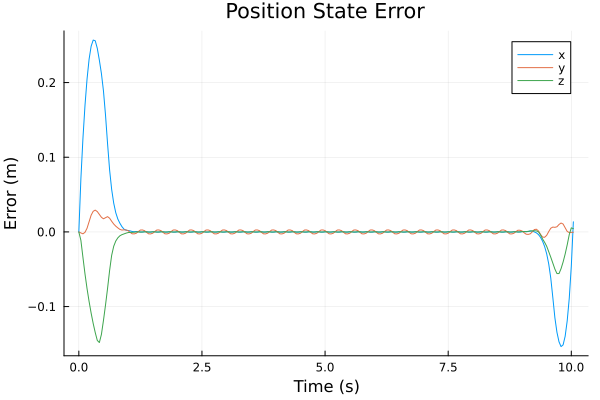

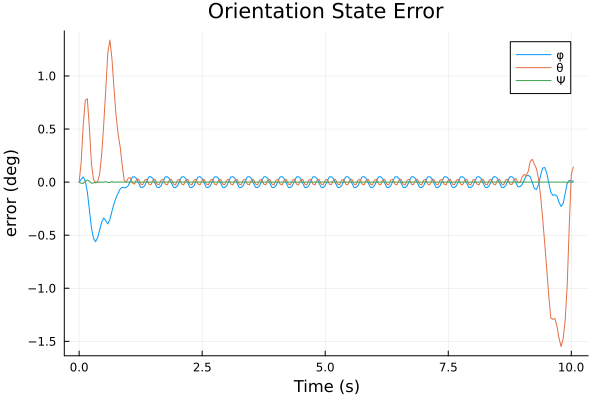

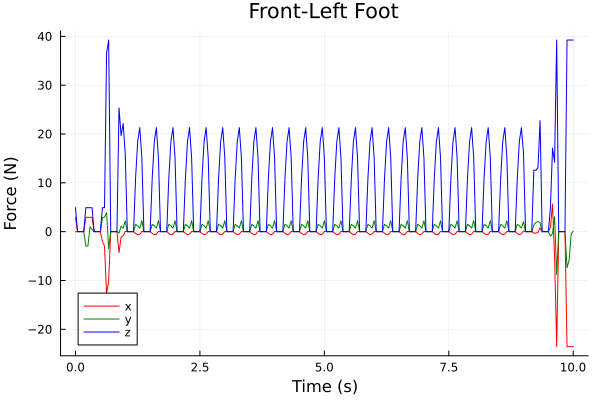

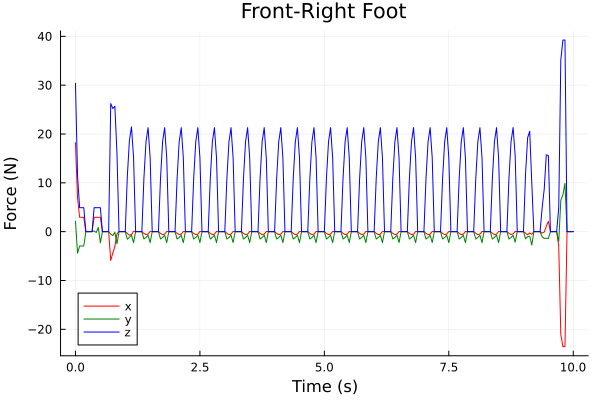

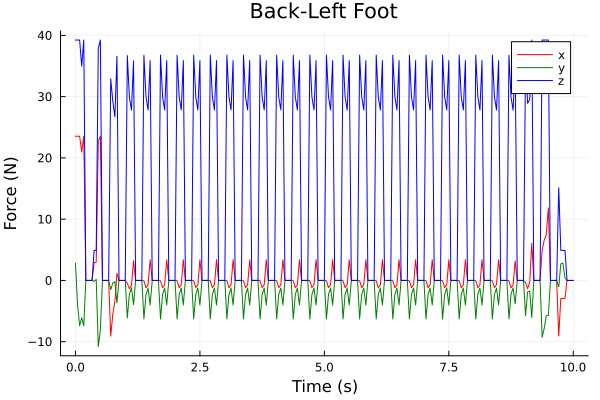

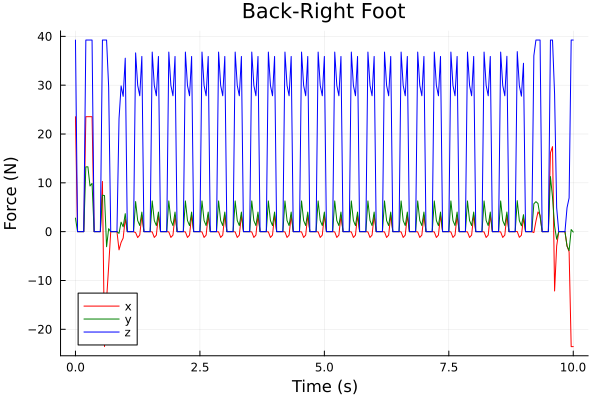

In [5]:
nx = 13
nu = 12

# LQR tracking cost to be used in ILC 
Q = diagm([100,100,100,100,100,100,1,1,1,1,1,0.01,0])
R = 0*diagm(ones(nu))
Qf = 100*Q

Uref = [zeros(12) for i = 1:N]
            
# calculate Jacobians
As = [zeros(nx,nx) for i = 1:N-1]
Bs = [zeros(nx,nu) for i = 1:N-1]

for i = 1:N-1
    As[i] = FD.jacobian(x -> rk4(model, dynamics, x, Uref[i], r_fl[i], r_fr[i], r_bl[i], r_br[i], dt), Xref[i])
    Bs[i] = FD.jacobian(u -> rk4(model, dynamics, Xref[i], u, r_fl[i], r_fr[i], r_bl[i], r_br[i], dt), Uref[i])
end

# create variables 
X = cvx.Variable(nx, N)
U = cvx.Variable(nu, N-1)

# cost function (tracking cost on Xref, Uref)
cost = 0.0
for k = 1:N-1
    # add stagewise cost 
    cost += 0.5*cvx.quadform(X[:,k] - Xref[k],Q) + 0.5*cvx.quadform(U[:,k],R)
end

cost += 0.5*cvx.quadform(X[:,N] - Xref[N],Qf)

# problem instance
prob = cvx.minimize(cost)

# initial condition constraint
prob.constraints += (X[:,1] == Xref[1])

# dynamics constraints
for k = 1:(N-1)
    prob.constraints += (X[:,k+1] == As[k]*X[:,k] + Bs[k]*U[:,k])
end

# gait constraints (only able to use feet when they are on the ground)
for k = 1:N-1
    if fl_timing[k] == 0
        prob.constraints += (U[3,k] == 0)
    else
        prob.constraints += (U[3,k] >= -model.m*model.g*0.1)  
        prob.constraints += (U[3,k] <= -model.m*model.g*0.8)        
    end
    if fr_timing[k] == 0
        prob.constraints += (U[6,k] == 0)
    else
        prob.constraints += (U[6,k] >= -model.m*model.g*0.1)
        prob.constraints += (U[6,k] <= -model.m*model.g*0.8)   
    end
    if bl_timing[k] == 0
        prob.constraints += (U[9,k] == 0)
    else
        prob.constraints += (U[9,k] >= -model.m*model.g*0.1) 
        prob.constraints += (U[9,k] <= -model.m*model.g*0.8)  
    end
    if br_timing[k] == 0
        prob.constraints += (U[12,k] == 0)
    else
        prob.constraints += (U[12,k] >= -model.m*model.g*0.1) 
        prob.constraints += (U[12,k] <= -model.m*model.g*0.8)  
    end
end

#friction constraints (friction cone)
for k = 1:N-1
    #front left
    prob.constraints += (U[1,k] <= model.mu * U[3,k])
    prob.constraints += (U[1,k] >= -model.mu * U[3,k])
    prob.constraints += (U[2,k] <= model.mu * U[3,k])
    prob.constraints += (U[2,k] >= -model.mu * U[3,k])
    #front right
    prob.constraints += (U[4,k] <= model.mu * U[6,k])
    prob.constraints += (U[4,k] >= -model.mu * U[6,k])
    prob.constraints += (U[5,k] <= model.mu * U[6,k])
    prob.constraints += (U[5,k] >= -model.mu * U[6,k])
    #back left
    prob.constraints += (U[7,k] <= model.mu * U[9,k])
    prob.constraints += (U[7,k] >= -model.mu * U[9,k])
    prob.constraints += (U[8,k] <= model.mu * U[9,k])
    prob.constraints += (U[8,k] >= -model.mu * U[9,k])
    #back right
    prob.constraints += (U[10,k] <= model.mu * U[12,k])
    prob.constraints += (U[10,k] >= -model.mu * U[12,k])
    prob.constraints += (U[11,k] <= model.mu * U[12,k])
    prob.constraints += (U[11,k] >= -model.mu * U[12,k])
end

cvx.solve!(prob, ECOS.Optimizer; silent_solver = false) #solver does the heavy lifting

# get X and U
X = vec_from_mat(X.value)
U = vec_from_mat(U.value)

#simulate to see if our dynamics are right
Xsim = [zeros(12) for i = 1:N]
Xsim[1] = Xref[1]

for i = 1:N-1
    Xsim[i+1] = rk4(model, dynamics, Xsim[i], U[i], r_fl[i], r_fr[i], r_bl[i], r_br[i], dt)
end

#plots
Xm= hcat(X...)
Um = hcat(U...)
Xrefm = hcat(Xref...)
Urefm = hcat(Uref...)
Xsim = hcat(Xsim...)
r1 = hcat(r_fl...)
r2 = hcat(r_fr...)
r3 = hcat(r_bl...)
r4 = hcat(r_br...)

# @show (hcat(r3...) - Xrefm[1:3,:])[1:3,:]

# plot(t_vec[1:end-1], Xm[1:6,:]', ls = :dash, label = "reference",
# xlabel = "t (s)", ylabel = "state", title = "State")
# display(plot(Xm[1,:], Xm[2,:], xlabel = "x", ylabel = "y", title = "Quadruped XY Path"))
plot(Xrefm[1,:], Xrefm[2,:], ls = :dash, label = "reference",
xlabel = "x (m)", ylabel = "y (m)", title = "Trajectory")
display(plot!(Xm[1,:], Xm[2,:], label = "actual"))

# plot(t_vec[1:end-1], Xrefm[1:3,:]', ls = :dash, label = "reference")
# display(plot!(t_vec[1:end-1], Xm[1:3,:]'))

# plot(t_vec[1:end-1], Xrefm[7:9,:]', ls = :dash, label = "reference")
# display(plot!(t_vec[1:end-1], Xm[7:9,:]'))

display(plot(t_vec[1:end-1], Xrefm[1:3,:]' - Xm[1:3,:]', label=["x" "y" "z"], xlabel = "Time (s)", ylabel = "Error (m)", title = "Position State Error"))

display(plot(t_vec[1:end-1], (Xrefm[4:6,:]' - Xm[4:6,:]') * 180 / 3.14, label=["φ" "θ" "Ψ"], xlabel = "Time (s)", ylabel = "error (deg)", title = "Orientation State Error"))

# display(plot(scatter(x=1:N, y=r1[1:2,:]', mode="markers")))
    
# plot(t_vec[1:end-2], Urefm[1:3,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FL")
display(plot(t_vec[1:end-2], Um[1:3,:]', lc = [:red :green :blue], label=["x" "y" "z"], xlabel = "Time (s)", ylabel = "Force (N)", title = "Front-Left Foot"))
#     plot(t_vec[1:end-2], Urefm[4:6,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FR")
display(plot(t_vec[1:end-2], Um[4:6,:]', lc = [:red :green :blue], label=["x" "y" "z"], xlabel = "Time (s)", ylabel = "Force (N)", title = "Front-Right Foot"))
# plot(t_vec[1:end-2], Urefm[7:9,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BL")
display(plot(t_vec[1:end-2], Um[7:9,:]', lc = [:red :green :blue], label=["x" "y" "z"], xlabel = "Time (s)", ylabel = "Force (N)", title = "Back-Left Foot"))
# plot(t_vec[1:end-2], Urefm[10:12,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BR")
display(plot(t_vec[1:end-2], Um[10:12,:]', lc = [:red :green :blue], label=["x" "y" "z"], xlabel = "Time (s)", ylabel = "Force (N)", title = "Back-Right Foot"))